$x$ is a vector of an image... $f(x) \in \{0,\ldots,9\}$

$f(x) = \text{sign-type-function}(Wx + b)$

In [1]:
using MLDatasets, Plots, LinearAlgebra, ProgressMeter, Statistics

In [2]:
# load full training set
train_x, train_y = MNIST.traindata()

# load full test set
test_x,  test_y  = MNIST.testdata();

In [3]:
X_total = hcat(ones(60000), hcat([float.(vec(train_x[:,:,i])) for i in 1:60000]...)');
size(X_total)

(60000, 785)

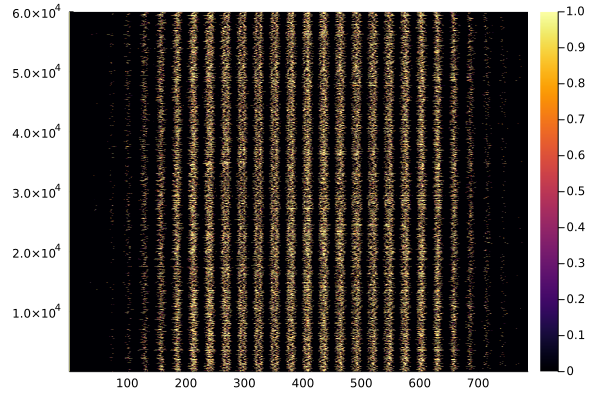

In [4]:
heatmap(X_total)

In [5]:
X_per_digit = [X_total[train_y .== i,:] for i in 0:9]
size.(X_per_digit)

10-element Vector{Tuple{Int64, Int64}}:
 (5923, 785)
 (6742, 785)
 (5958, 785)
 (6131, 785)
 (5842, 785)
 (5421, 785)
 (5918, 785)
 (6265, 785)
 (5851, 785)
 (5949, 785)

# One vs. Rest Linear

Make $10$ classifiers, one for each digit.... where in each classifier you comapre the digit being what you want (+1), or one of the other $9$ digits (-1).

$$
||w^\top x - y||
$$

$$
w^* = A^\dagger y
$$

In [7]:
pinv_total = pinv(X_total)

"""
Make a classifier for the `digit_pos`.
"""
function make_one_vs_one_pred(digit_pos)
    Y_one_vs_rest = 2(train_y .== digit_pos) .- 1
    
    #\beta is the set of weights for the specific digit...
    β_one_vs_rest = pinv_total*Y_one_vs_rest
    pred_one_vs_rest(img) = vcat(1,vec(img))'β_one_vs_rest
    return pred_one_vs_rest
end

preds_one_vs_rest = [make_one_vs_one_pred(i) for i in 0:9]

#Here is the "one vs. rest"
predict_one_vs_rest(img) = argmax([preds_one_vs_rest[i+1](img) for i in 0:9]) - 1

accuracy_one_vs_rest = mean([predict_one_vs_rest(test_x[:,:,i]) == test_y[i] for i in 1:10000]) 

@show accuracy_one_vs_rest;

accuracy_one_vs_rest = 0.8603


In [8]:
predictions = [predict_one_vs_rest(test_x[:,:,i]) for i in 1:10000]
confusionMatrix = [sum((predictions .== i) .& (test_y .== j)) for i in 0:9, j in 0:9]


10×10 Matrix{Int64}:
 944     0   18    4    0   23   18    5   14   15
   0  1107   54   17   22   18   10   40   46   11
   1     2  813   23    6    3    9   16   11    2
   2     2   26  880    1   72    0    6   30   17
   2     3   15    5  881   24   22   26   27   80
   7     1    0   17    5  659   17    0   40    1
  14     5   42    9   10   23  875    1   15    1
   2     1   22   21    2   14    0  884   12   77
   7    14   37   22   11   39    7    0  759    4
   1     0    5   12   44   17    0   50   20  801

# One vs. One

In [21]:
function make_one_vs_one_pred(digit_pos, digit_neg)
    X_one_vs_one = vcat(X_per_digit[digit_pos+1],X_per_digit[digit_neg+1])
    Y_one_vs_one = vcat(ones(size(X_per_digit[digit_pos+1])[1]), -ones(size(X_per_digit[digit_neg+1])[1]))
    β_one_vs_one = pinv(X_one_vs_one)*Y_one_vs_one
    pred_one_vs_one(img) = vcat(1,vec(img))'β_one_vs_one
    return pred_one_vs_one
end

preds_one_vs_one = Dict()
@showprogress for i in 0:9
    @showprogress for j in 0:9
        i == j && continue
        preds_one_vs_one[(i,j)] = make_one_vs_one_pred(i,j)
    end
end

predict_one_vs_one(img) = argmax([sum([preds_one_vs_one[(i,j)](img) for j in setdiff(0:9,i)]) for i in 0:9])-1

accuracy_one_vs_one = mean([predict_one_vs_one(test_x[:,:,i]) == test_y[i] for i in 1:10000]) 

@show accuracy_one_vs_one;

Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:01:17


accuracy_one_vs_one = 0.6001


In [23]:
predict_one_vs_one_sign(img) = argmax([sum([sign(preds_one_vs_one[(i,j)](img)) for j in setdiff(0:9,i)]) for i in 0:9])-1

accuracy_one_vs_one_sign = mean([predict_one_vs_one_sign(test_x[:,:,i]) == test_y[i] for i in 1:10000]) 


0.9297

In [24]:
predictions = [predict_one_vs_one_sign(test_x[:,:,i]) for i in 1:10000]
confusionMatrix = [sum((predictions .== i) .& (test_y .== j)) for i in 0:9, j in 0:9]


10×10 Matrix{Int64}:
 961     0    9    9    2    7    6    1    7    6
   0  1120   18    1    4    5    5   16   17    5
   1     3  936   18    6    3   12   17    8    1
   1     3   12  926    1   30    0    3   23   11
   0     1   10    2  931    8    5   11   10   30
   6     1    5   20    1  800   19    1   36   12
   8     4   10    1    7   17  908    0   10    0
   3     1   10    7    4    2    1  955   10   21
   0     2   22   21    3   15    2    1  840    3
   0     0    0    5   23    5    0   23   13  920

### A better alternative for one vs. one is to do majority rounds

In [56]:
function predict_one_vs_one_counts(img)
    num_wins = zeros(Int,10)
    
    for i in 0:9
        for j in (i+1):9
            z = preds_one_vs_one[(i,j)](img)
            z > 0 ? (num_wins[i+1] += 1) : (num_wins[j+1] += 1)     
        end
    end
    max_val = maximum(num_wins)
    if sum(num_wins .== max_val) > 1
        println("Tie between ", sum(num_wins .== max_val))
    end
    return argmax(num_wins) - 1
end

predict_one_vs_one_counts (generic function with 1 method)

In [57]:
accuracy_one_vs_one_counts = mean([predict_one_vs_one_counts(test_x[:,:,i]) == test_y[i] for i in 1:10000]) 

Tie between 3
Tie between 3
Tie between 3
Tie between 2
Tie between 2
Tie between 2
Tie between 2
Tie between 2
Tie between 3
Tie between 2
Tie between 2
Tie between 2
Tie between 2
Tie between 2
Tie between 2
Tie between 2
Tie between 2
Tie between 2
Tie between 2
Tie between 2
Tie between 2
Tie between 2
Tie between 5
Tie between 2
Tie between 2
Tie between 2
Tie between 3
Tie between 2
Tie between 2
Tie between 2
Tie between 2
Tie between 2
Tie between 2
Tie between 2
Tie between 2
Tie between 3
Tie between 2
Tie between 3
Tie between 2
Tie between 3
Tie between 2
Tie between 2
Tie between 2
Tie between 2
Tie between 4
Tie between 2
Tie between 2
Tie between 2
Tie between 2
Tie between 2
Tie between 2
Tie between 2
Tie between 2
Tie between 2
Tie between 2
Tie between 3
Tie between 3
Tie between 3
Tie between 2
Tie between 2
Tie between 2
Tie between 2
Tie between 2
Tie between 2
Tie between 2
Tie between 3
Tie between 2
Tie between 2
Tie between 2
Tie between 2
Tie between 4
Tie be

0.9297

test_y[i] = 4
predict_one_vs_one_counts(test_x[:, :, i]) = 4


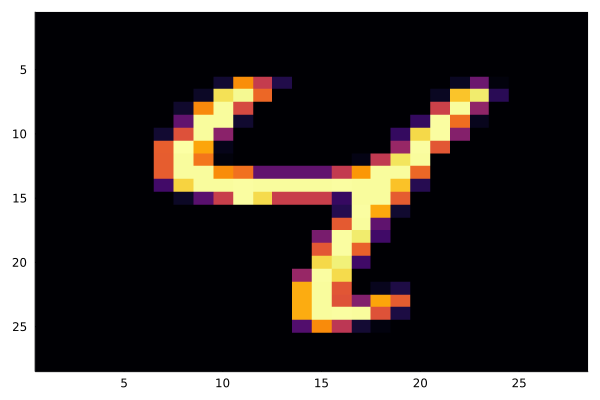

In [100]:
i = 7
@show test_y[i]
@show predict_one_vs_one_counts(test_x[:,:,i])
heatmap(test_x[:,:,i]',yflip=true,legend=false)

In [73]:
sum(test_y .!= i_we_consider)

9018

In [101]:
ii = 7
img = test_x[:,:,ii]
for i_we_consider in 0:9
    ss = sum([preds_one_vs_one[(i_we_consider,j)](img) for j in setdiff(0:9,i_we_consider)])
    @show (i_we_consider, ss)
end
predict_one_vs_one(img)

(i_we_consider, ss) = (0, -4.47019763183282)
(i_we_consider, ss) = (1, -5.769222620402233)
(i_we_consider, ss) = (2, -4.167695446718268)
(i_we_consider, ss) = (3, 0.06395619868736735)
(i_we_consider, ss) = (4, 6.520050604882762)
(i_we_consider, ss) = (5, 1.7110932035252806)
(i_we_consider, ss) = (6, -1.3275876730862142)
(i_we_consider, ss) = (7, 1.4569314222370333)
(i_we_consider, ss) = (8, 2.370744998612331)
(i_we_consider, ss) = (9, 3.611926944091167)


4

In [85]:
preds_one_vs_one[(2,5)](img)

0.18017714177786284

In [87]:
i_we_consider

8

In [92]:
[preds_one_vs_one[(5,j)](img) for j in setdiff(0:9,5)]


9-element Vector{Float64}:
  1.4317746585018023
 -0.9813866740050795
 -0.3343044378044372
 -0.29626796457239185
  0.11931601766363874
  0.30026852790360253
 -0.45871288185630343
 -0.5946576130923574
 -0.16880350209480519

In [109]:
predictions = [accuracy_one_vs_one_counts(test_x[:,:,i]) for i in 1:10000]
confusionMatrix = [sum((predictions .== i) .& (test_y .== j)) for i in 0:9, j in 0:9]


LoadError: MethodError: objects of type Float64 are not callable
Maybe you forgot to use an operator such as [36m*, ^, %, / etc. [39m?

# Multiclass classifier

Multivariate-regression model....

Take an input of 785 and return an output which is a 10 dimensional vector.

$W_{10 \times 785} X^\top$ will give you 60,000 vectors of length $10$.

$$
f(x) = W_{10 \times 784} x + b_{10}
$$

In [ ]:
𝑊10×785

In [48]:
W = rand(10,785)

10×785 Matrix{Float64}:
 0.356979  0.268505  0.639226   0.382653   …  0.956057  0.692347    0.484672
 0.556674  0.849462  0.695945   0.254617      0.94036   0.987717    0.990057
 0.751468  0.911308  0.858985   0.631071      0.491438  0.18366     0.957706
 0.636966  0.249663  0.265009   0.178126      0.160516  0.427165    0.882362
 0.359407  0.560056  0.337557   0.828995      0.784581  0.422235    0.993326
 0.641927  0.767627  0.585723   0.421231   …  0.391732  0.988874    0.724906
 0.317758  0.955932  0.0943696  0.382774      0.503416  0.815056    0.960927
 0.675663  0.869582  0.0904022  0.0314875     0.1039    0.00089535  0.70478
 0.803929  0.864652  0.952391   0.427592      0.505718  0.153908    0.336419
 0.882705  0.415927  0.505746   0.0666468     0.953791  0.0946118   0.881573

In [49]:
W*X_total'

10×60000 Matrix{Float64}:
 59.2423  60.3648  39.0125  34.0399  …  50.8453  44.2081  39.1774  34.8459
 57.0913  63.3112  39.3098  35.7401     54.7145  45.5224  44.5479  41.5527
 54.3065  62.0731  40.8359  35.7271     56.6353  43.2821  43.8282  41.3362
 57.2707  62.5939  37.8391  31.6926     52.1818  49.1109  38.3058  45.7467
 51.5595  58.609   35.3453  33.445      52.3004  42.3676  37.1919  38.2559
 55.1243  61.4145  40.1505  35.2398  …  58.5951  44.5735  40.1831  44.8075
 57.3252  64.2573  39.4538  33.2999     52.7441  46.8905  42.4196  39.936
 55.2224  59.1694  39.1703  35.3294     53.618   43.8386  35.9918  36.5552
 57.8373  64.767   40.3124  38.2315     52.9456  45.6183  44.3175  42.8989
 53.2519  55.2016  37.5158  32.697      53.7569  44.6415  35.2991  37.951

In [27]:
pinv_total = pinv(X_total)

785×60000 Matrix{Float64}:
 -1.62871e-6    6.06264e-5    0.000121103  …   8.64341e-5    0.000113218
 -2.46715e-15   4.1137e-15   -4.27116e-15     -1.12434e-14   1.01236e-14
  1.21142e-14  -1.30063e-14   1.18796e-14      2.78477e-14  -2.4599e-14
 -3.28793e-15   4.90503e-15  -4.84655e-15     -1.1556e-14    1.10956e-14
 -2.84059e-15   3.42563e-15  -2.69293e-15     -6.38076e-15   6.41825e-15
 -8.1094e-15    1.09814e-14  -1.00841e-14  …  -2.51373e-14   2.22512e-14
 -8.10768e-15   6.98125e-15  -6.7639e-15      -1.35302e-14   1.38528e-14
 -7.15972e-15   6.7286e-15   -5.94933e-15     -1.31386e-14   1.30833e-14
 -9.62252e-16   2.10182e-15  -1.61422e-15     -5.15562e-15   3.51575e-15
  1.40528e-15  -9.94218e-16  -1.22508e-16      2.04293e-15  -1.19747e-15
 -1.5194e-14    1.46317e-14  -1.39084e-14  …  -3.20661e-14   3.01714e-14
 -5.23148e-15   5.5509e-15   -5.43933e-15     -1.42185e-14   1.21386e-14
 -7.54063e-15   6.34767e-15  -5.20298e-15     -1.2097e-14    1.09127e-14
  ⋮                      

# Multinomial Regression

In [31]:
trainData = hcat([vec(float.(train_x[:,:,i])) for i in 1:60000]...)
trainLabels = train_y

testData = hcat([vec(float.(test_x[:,:,i])) for i in 1:10000]...)
testLabels = test_y;

In [39]:
using Flux, Random#, Statistics, BSON, Random, StatsBase, Plots; pyplot()
using Flux: params, onehotbatch, crossentropy, update!
Random.seed!(1)

W = randn(10,28*28)
b = randn(10)

logisticM(imgVec) = softmax(W*imgVec .+ b)
logisticMclassifier(imgVec) = argmax(logisticM(imgVec))-1
loss(x,y) = crossentropy(logisticM(x),onehotbatch(y,0:9))
opt = ADAM(0.01)
miniBatchSize = 1000;

In [41]:
lossValue = 0.0
lossArray = []
epochNum = 0
while true
    global lossValue
    prevLossValue = lossValue
    for batch in Iterators.partition(1:nTrain,miniBatchSize)
      gs = gradient(()->loss(trainData[:,batch],trainLabels[batch]),params(W,b))
      for p in (W,b)
          update!(opt,p,gs[p])
      end
    end
    global epochNum += 1
    lossValue = loss(trainData,trainLabels)
    push!(lossArray,lossValue)
    print(".");flush(stdout)
    abs(prevLossValue-lossValue) < 5e-4 && break
end

println("\nNumber of epochs: ", epochNum)
acccuracy = mean([logisticMclassifier(testData[:,k]) for k in 1:nTest]
                .== testLabels)
println("Accuracy: ", acccuracy)

..
Number of epochs: 2
Accuracy: 0.9058


In [ ]:
Number of epochs: 83
Accuracy: 0.9085

# Logistic regression one vs. rest

In [46]:
using Flux: binarycrossentropy

"""
Make a classifier for the `digit_pos`.
"""
function make_one_vs_one_pred_logistic(digit_pos)
    Y_one_vs_rest = (train_y .== digit_pos) 
    
    w = randn(28*28)
    b = randn()

    logistic_digit(imgVec) = sigmoid(W'*imgVec .+ b)
    loss(x,y) = binarycrossentropy(logisticM(x),onehotbatch(y,0:9))
    opt = ADAM(0.01)
    miniBatchSize = 1000;
    
    print("Training for one vs. rest of digit $digit_pos")
    lossValue = 0.0
    lossArray = []
    epochNum = 0
    while true
        global lossValue
        prevLossValue = lossValue
        for batch in Iterators.partition(1:nTrain,miniBatchSize)
          gs = gradient(()->loss(trainData[:,batch],trainLabels[batch]),params(W,b))
          for p in (W,b)
              update!(opt,p,gs[p])
          end
        end
        global epochNum += 1
        lossValue = loss(trainData,trainLabels)
        push!(lossArray,lossValue)
        print(".");flush(stdout)
        abs(prevLossValue-lossValue) < 5e-4 && break
    end
    
    logisticMclassifier(imgVec) = logistic_digit(imgVec) > 0.5
    pred_one_vs_rest(img) = b + vec(img)'*w
    return pred_one_vs_rest
end

preds_one_vs_rest_logistic = [make_one_vs_one_pred(i) for i in 0:9]

# #Here is the "one vs. rest"
# predict_one_vs_rest(img) = argmax([preds_one_vs_rest[i+1](img) for i in 0:9]) - 1

# accuracy_one_vs_rest = mean([predict_one_vs_rest(test_x[:,:,i]) == test_y[i] for i in 1:10000]) 

# @show accuracy_one_vs_rest;